In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
#sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/')
from noshellavg_v2 import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

/n/home00/lee.5922/.local/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


##### Call class. shot noise = 0, FoG = 0

In [319]:
# b = galaxy bias
# f = structure growth rate
# s = velocity dispersion in FoG term 
# nn = shot noise 
cosmo = class_covariance(KMIN=0.001, KMAX = 10, n=3000, RMIN = 0.001, RMAX = 200, n2 = 41, 
                         b = 2.0, f = 0.74, s=0.0, nn=0, rscale = 'lin', kscale='log')

# calling matter power spectrum from camb
cosmo.MatterPower()

# P model and Xi model comparison with theory 

Compare theoretical P(k) and my module

Theory:
$P_0 = (b^2 + 2/3 bf + 1/5 f^2) P_{matter}(k)$

In [320]:
Pmatter = cosmo.Pm_interp(cosmo.kbin) #from camb

P0_theory = (cosmo.b**2 + 2./3*cosmo.b*cosmo.f + 1./5 *cosmo.f**2)*Pmatter 
P0_mine = cosmo.multipole_P(0)

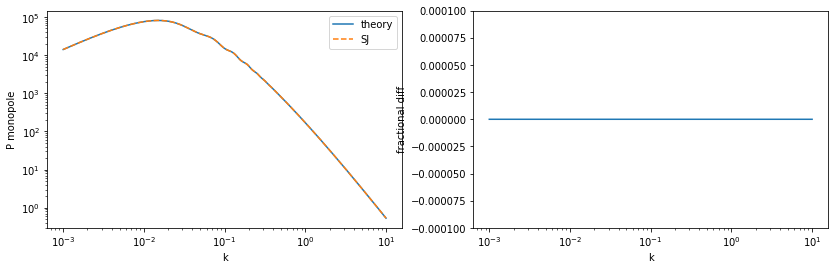

In [321]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,4))
ax.loglog(cosmo.kbin, P0_theory, label='theory')
ax.loglog(cosmo.kbin, P0_mine, '--', label = 'SJ')
ax.set_xlabel('k')
ax.set_ylabel('P monopole')
ax.legend()

ax2.semilogx(cosmo.kbin, 1.-P0_theory/P0_mine)
ax2.set_ylim(-1e-04, 1e-04)
ax2.set_xlabel('k')
ax2.set_ylabel('fractional diff')

Compare theoretical \xi(r) and my module

Thoery :

$\xi_0 = (b^2 + 2/3 bf + 1/5 f^2) \xi_{matter}(r)$

In [322]:
Pmatter = cosmo.Pm_interp(cosmo.kbin) #from camb

# Fourier transform of matter Power spectrum
xi_matter = cosmo.fourier_transform_kr(0, cosmo.kbin, Pmatter) 
xi0_theory = (cosmo.b**2 + 2./3*cosmo.b*cosmo.f + 1./5 *cosmo.f**2)*xi_matter
xi0_mine = cosmo.multipole_Xi(0)

(-1e-12, 1e-12)

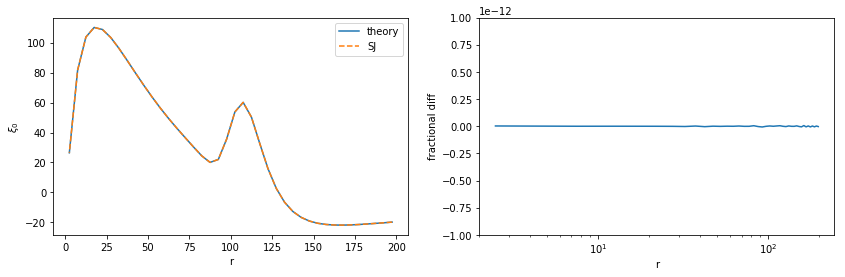

In [323]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,4))
ax.plot(cosmo.rcenter, cosmo.rcenter**2*xi0_theory, label = 'theory')
ax.plot(cosmo.rcenter, cosmo.rcenter**2*xi0_mine, '--', label='SJ')
ax.set_xlabel('r')
ax.set_ylabel(r'$\xi_0$')
ax.legend()

ax2.semilogx(cosmo.rcenter, 1.-xi0_theory/xi0_mine)
ax2.set_xlabel('r')
ax2.set_ylabel('fractional diff')
ax2.set_ylim(-1e-12, 1e-12)

# dp/db and dxi/db comparison with theory

Theory : 

$\frac{dp_0}{db} = \left(2b + \frac{2}{3} f \right) P_{m}(k)$

$\frac{d\xi_0}{db} = \left(2b + \frac{2}{3} f \right) \xi_{m}(k)$

In [324]:
Pmatter = cosmo.Pm_interp(cosmo.kbin) #matter power spectrum from camb

In [325]:
# theory
dpdb_theory = (2*cosmo.b + 2./3*cosmo.f) * Pmatter
dxidb_theory = (2*cosmo.b + 2./3*cosmo.f) * xi_matter

# derivative dp/db, dxi/db
dpdb_mine, _, _ = cosmo.derivative_P_bfs(0)
dxidb_mine, _, _ = cosmo.derivative_bfs(0)   # Fourier transform of dp/db

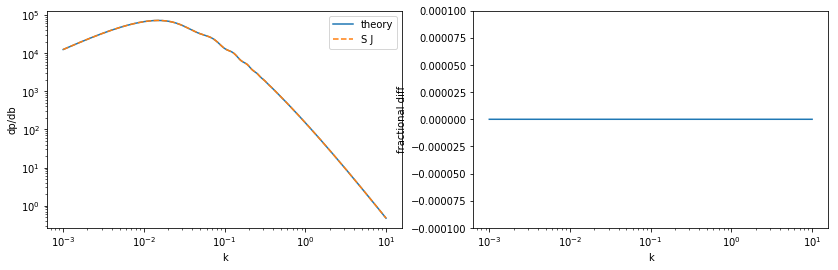

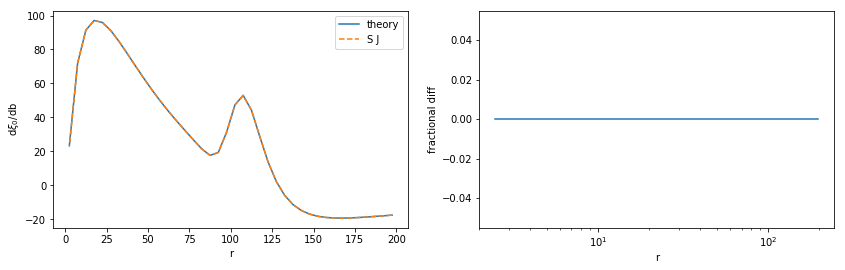

In [326]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,4))
ax.loglog(cosmo.kbin, dpdb_theory, label='theory')
ax.loglog(cosmo.kbin, dpdb_mine, '--', label = 'S J')
ax.set_xlabel('k')
ax.set_ylabel('dp/db')
ax.legend()

ax2.semilogx(cosmo.kbin, 1.-dpdb_theory/dpdb_mine)
ax2.set_ylim(-1e-04, 1e-04)
ax2.set_xlabel('k')
ax2.set_ylabel('fractional diff')

fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,4))
ax.plot(cosmo.rcenter, cosmo.rcenter**2*dxidb_theory, label = 'theory')
ax.plot(cosmo.rcenter, cosmo.rcenter**2*dxidb_mine, '--', label='S J')
ax.set_xlabel('r')
ax.set_ylabel(r'd$\xi_0$/db')
ax.legend()

ax2.semilogx(cosmo.rcenter, 1.-dxidb_theory/dxidb_theory)
ax2.set_xlabel('r')
ax2.set_ylabel('fractional diff')
#ax2.set_ylim(-1e-13, 1e-13)

### Covariance Matrices 

In [327]:
# calculate covariance matrix
covp_model = cosmo.covariance_PP(0,0)        # cov P monopole
covxi_model = cosmo.covariance_Xi(0,0)    # cov Xi monopole  : double bessel FT of covp_model
covpxi_model = cosmo.covariance_PXi(0,0)  # cov Pxi monopole : FT of covp_model

### In order to simply the problem, choose only 1 kbin and only 1 rbin

In [328]:
#dpdb, dxidb
dpdb_model, _, _ = cosmo.derivative_P_bfs(0)
dxidb_model, _,_ = cosmo.derivative_bfs(0)

In [329]:
def analytic_inv(M):
    a = M[0,0]
    b = M[0,1]
    c = M[1,0]
    d = M[1,1]
    det = np.fabs(a*d - b*c)
    
    M[0,0] = d
    M[1,1] = a
    M[0,1] = -b
    M[1,0] = -c
    return 1./det * M 

In [330]:
def check_estimator( F=None, kind = 0, kN=1, rind=0, rN=1):
    """
    F : output file. if None, results will be printed out 
    kind : kbin index
    rind : rbin index
    kN : number of k bin that will be included in covariance calculation. if 1, use only one kbin.
    rN : number of r bin that will be included in covariance calculation. if 1, use only one rbin.    
    """
    
    from numpy.linalg import inv
    
    krange =  'k = {:10} ~ {:10}'.format(cosmo.kbin[kind], cosmo.kbin[kind+kN])
    rrange = 'r = {:10} ~ {:10}'.format(cosmo.rcenter[rind+rN], cosmo.rcenter[rind])

    if F is None : 
        print krange
        print rrange

    # dp/db and dxi/db at a given k and r scale.
    dpdb = dpdb_model[kind:kind+kN]
    dxidb = dxidb_model[rind:rind+rN]
    dcdb = np.hstack((dpdb, dxidb))

    # covariance matrix at a given k and r scale
    cov_p = covp_model[kind:kind+kN, kind:kind+kN]
    cov_xi = covxi_model[rind:rind+rN, rind:rind+rN]
    cov_pxi = covpxi_model[kind:kind+kN, rind:rind+rN]
    cov_tot = np.vstack(( np.hstack((cov_p, cov_pxi)), np.hstack((cov_pxi.T, cov_xi)) ))

    # Bias Fisher matrix 
    F_pb = np.dot( np.dot( dpdb, inv(cov_p) ), dpdb.T )
    F_xb = np.dot( np.dot( dxidb, inv(cov_xi) ), dxidb.T )
    F_cb = np.dot( np.dot( dcdb, inv(cov_tot) ), dcdb.T )
    
    F_db = F_pb + F_xb

    # Check if the inverse of covariance matrix has invalid value in diagonals.
    if np.sum( inv(cov_tot).diagonal() < 0) > 0 : print 'Warning : negative Fisher diagonals'
        
    # Getting sigma_b 
    sigma_pb = np.sqrt(1./F_pb)  # P only
    sigma_xb = np.sqrt(1./F_xb)  # Xi only
    sigma_cb = np.sqrt(1./F_cb)  # combined
    sigma_db = np.sqrt(1./F_db)  # diff sky
    
    # Check if the results are valid or not.
    # if combined error is smaller than diff sky error, return 1, otherwise return 0.
    """
    
    mask12 = 1
    mask08 = 1
    if sigma_cb < sigma_db : 
        if F is None : print "Failed : different sky estimator > Combined estimator!!!"
        mask = 1
        if sigma_cb > 0.99*sigma_db : mask12 = 0
        else : mask12 = 1
    else: 
        if F is None : print 'Success'
        mask = 0
        if sigma_cb < 1.001*sigma_db : mask08 = 0
        else :mask08 = 1
    """

    #if mask12 == 1 : print mask12  
    if F is None : 
        print '--------------------------------------'
        print 'sigma_p    = ',sigma_pb
        print 'sigma_xi   = ',sigma_xb
        print 'sigma_com  = ',sigma_cb
        print 'sigma_diff = ',sigma_db
        print ''
    else :
        
        #F.write('{} {} {} {}\n'.format(cosmo.rcenter[rind+rN], cosmo.rcenter[rind], mask, mask12))
        F.write('{} {} {} {}\n'.format(cosmo.rcenter[rind+rN], cosmo.rcenter[rind], sigma_cb, sigma_db))
        F.flush()  

### Test for arbitrary 1 kbin and 1 rbin

Test with the smallest r bin and the smallest k bin : succeed

In [336]:
check_estimator(F=None, kind=1, kN=1, rind=38, rN=1)

k = 0.00100307585794 ~ 0.00100616117679
r =  2.5009875 ~  7.5009625
--------------------------------------
sigma_p    =  58.38543517946506
sigma_xi   =  0.0021927122783176557
sigma_com  =  0.002192712278307106
sigma_diff =  0.0021927122767713123



Test with the smallest k bin and the largest r bin : Test Failed. 

In [337]:
check_estimator(F=None, kind=1, kN=1, rind=1, rN=1)

k = 0.00100307585794 ~ 0.00100616117679
r = 187.5000625 ~ 192.5000375
--------------------------------------
sigma_p    =  58.38543517946506
sigma_xi   =  0.5319982877330953
sigma_com  =  0.5319740118538019
sigma_diff =  0.5319762044000348



### Test for all bins to see where the estimator fails.

##### Do calculation for $i_{th}$ kbin and $j_{th}$ rbin. 

In [344]:
kN = 10
rN = 1

In [345]:
import os

dir = '../data_txt/consistency_check_rN{}_kN{}_dr5/'.format(rN, kN)
if not os.path.exists(dir) : os.makedirs(dir)

for ki in range(cosmo.kbin.size-kN):  
    F = open(dir+'/consistency_check_k{}.txt'.format(ki), "w")
    #F.write('#' + krange )
    #F.write('# r1, r2, mask (1==failed, 2==success)\n')
    F.write('# r1, r2, sigma_c, sigma_d \n')
    for ri in range(cosmo.rcenter.size-rN):
        check_estimator(F=F, kind=ki, kN=kN, rind=ri, rN=rN)     
    print '{}/{} \r'.format(ki+1, cosmo.kbin.size-1),
    F.close()

"""
effectiver = np.zeros(( cosmo.kbin.size-kN, 2 ))
effectiver12 = np.zeros(( cosmo.kbin.size-kN, 2 ))
for ki in range(cosmo.kbin.size-kN):
    kcenter, _, mask, mask12= np.genfromtxt(dir+'/consistency_check_k{}.txt'.format(ki), unpack=True)
    mask = np.array(mask, dtype=bool)
    mask12 = np.array(mask12, dtype=bool)

    effective_r = cosmo.rcenter[:-rN][~mask]
    effective_r12 = cosmo.rcenter[:-rN][~mask12]
    
    #print effective_r12.min(), effective_r12.max()
    effectiver[ki,0] = effective_r.max()
    effectiver[ki,1] = effective_r.min()
    
    effectiver12[ki,0] = effective_r12.max()
    effectiver12[ki,1] = effective_r12.min()
    #F2.write('{} {} {}\n'.format(cosmo.kcenter_y[ki],effective_r.min(),effective_r.max() ) )
    #F2.flush()
    
DAT_effectiver = np.column_stack((cosmo.kbin[:-kN], effectiver[:,0], effectiver[:,1]))
np.savetxt(dir+'consistency_check_rlim.txt', DAT_effectiver, header='# kcenter, rmin, rmax')
DAT_effectiver12 = np.column_stack((cosmo.kbin[:-kN], effectiver12[:,0], effectiver12[:,1]))
np.savetxt(dir+'consistency_check_rlim12.txt', DAT_effectiver12, header='# kcenter, rmin, rmax')
"""

"\neffectiver = np.zeros(( cosmo.kbin.size-kN, 2 ))\neffectiver12 = np.zeros(( cosmo.kbin.size-kN, 2 ))\nfor ki in range(cosmo.kbin.size-kN):\n    kcenter, _, mask, mask12= np.genfromtxt(dir+'/consistency_check_k{}.txt'.format(ki), unpack=True)\n    mask = np.array(mask, dtype=bool)\n    mask12 = np.array(mask12, dtype=bool)\n\n    effective_r = cosmo.rcenter[:-rN][~mask]\n    effective_r12 = cosmo.rcenter[:-rN][~mask12]\n    \n    #print effective_r12.min(), effective_r12.max()\n    effectiver[ki,0] = effective_r.max()\n    effectiver[ki,1] = effective_r.min()\n    \n    effectiver12[ki,0] = effective_r12.max()\n    effectiver12[ki,1] = effective_r12.min()\n    #F2.write('{} {} {}\n'.format(cosmo.kcenter_y[ki],effective_r.min(),effective_r.max() ) )\n    #F2.flush()\n    \nDAT_effectiver = np.column_stack((cosmo.kbin[:-kN], effectiver[:,0], effectiver[:,1]))\nnp.savetxt(dir+'consistency_check_rlim.txt', DAT_effectiver, header='# kcenter, rmin, rmax')\nDAT_effectiver12 = np.column_stac

In [346]:
matrix = np.zeros((cosmo.rcenter.size-1, len(np.arange(0, 3000, 10))))
#fig, ax = plt.subplots()
for i, ki in enumerate(np.arange(0, 3000, 10)) : #cosmo.kbin.size-kN):
    
    k = cosmo.kbin[ki]
    r, _, sig_c, sig_d = np.genfromtxt(dir+'/consistency_check_k{}.txt'.format(ki), unpack=True)
    mask = sig_c > sig_d
    mask2 = sig_c > 1.01 * sig_d
    mask3 = sig_c < 0.99 * sig_d
    #ask12 = np.array(mask12, dtype=bool)
    #print matrix[:,i].size, mask.size
    matrix[:,i][mask] = 1
    matrix[:,i][mask2] = 2
    matrix[:,i][mask3] = 3
    #ax.plot(np.ones(r[mask].size)*k, r[mask], 'k.', alpha = 0.05 )
    #ax.plot(np.ones(r[mask2].size)*k, r[mask2], 'r.', alpha = 0.05 )
    #ax.plot(np.ones(r[mask3].size)*k, r[mask3], 'b.', alpha = 0.05 )
#ax.set_xscale('log')
#ax.set_xlim(1e-03, 10)

IOError: ../data_txt/consistency_check_rN1_kN10_dr5//consistency_check_k2990.txt not found.

/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


([<matplotlib.axis.XTick at 0x7f390392d210>,
 <a list of 5 Text xticklabel objects>)

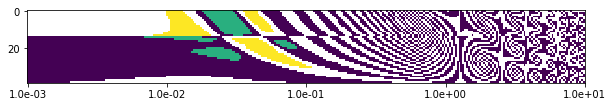

In [341]:
klogspacing = np.logspace(np.log10(1e-03), np.log10(10), 5)
klogspacing = tuple(['{:0.1e}'.format(klogspacing[i]) for i in range(5)])

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(np.log10(matrix) )

#plt.xticks(np.arange(8), tuple([str(klogspacing[i]) for i in range(8)]))
#ax.set_xscale('log')

plt.xticks( np.linspace(0, 300, 5), klogspacing)

##### rN = 1,  kN = 1

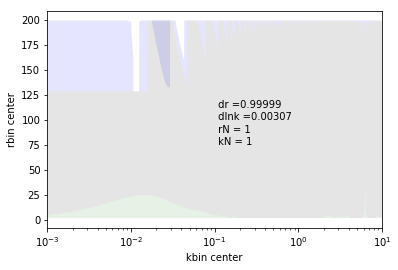

In [169]:
rN = 1
kN = 1
dir = '../data_txt/consistency_check_rN1_kN1/'
filename = dir+'/consistency_check_rlim.txt'
kcenter, effec_rmax, effec_rmin = np.loadtxt(filename, unpack=True)

filename12 = dir+'/consistency_check_rlim12.txt'
kcenter, effec_rmax12, effec_rmin12 = np.loadtxt(filename12, unpack=True)

fig, ax =plt.subplots()
#ax.plot(kcenter, effec_rmax, '-', color='grey', linewidth = 0.5)
#ax.plot(kcenter, effec_rmin, '-', color ='grey', linewidth = 0.5)

ax.fill_between(kcenter, effec_rmax, effec_rmin, where=effec_rmax >= effec_rmin, 
                facecolor='grey', alpha = 0.2,interpolate=True)

ax.fill_between(kcenter, effec_rmax12, effec_rmin12, 
                facecolor='blue', alpha = 0.1,interpolate=True)

#ax.fill_between(kcenter, effec_rmin12, effec_rmin, 
#                facecolor='green', alpha = 0.1,interpolate=True)

#ax.fill_between(kcenter, effec_rmax08, effec_rmin08, 
#                facecolor='red', alpha = 0.1,interpolate=True)


ax.set_ylabel('rbin center')
ax.set_xlabel('kbin center')
ax.text(0.1, 100, ' dr ={:0.5f}\n dlnk ={:0.5f}'.format(cosmo.dr, cosmo.dlnk) )
ax.text(0.1, 75, ' rN = {}\n kN = {}'.format(rN, kN))
ax.legend(loc='best')
ax.set_xlim(1e-03, 10)
ax.set_xscale('log')

fig.savefig(dir+'fig.png')

In [69]:
rN = 1
kN = 1
dir = '../data_txt/consistency_check_rN1_kN1_dr5/'
filename = dir+'/consistency_check_rlim.txt'
kcenter, effec_rmax, effec_rmin = np.loadtxt(filename, unpack=True)
fig, ax =plt.subplots()
ax.plot(kcenter, effec_rmax, '-', color='grey', linewidth = 0.5)
ax.plot(kcenter, effec_rmin, '-', color ='grey', linewidth = 0.5)

ax.fill_between(kcenter, effec_rmax, effec_rmin, where=effec_rmax >= effec_rmin, 
                facecolor='grey', alpha = 0.2,interpolate=True)

ax.set_ylabel('rbin center')
ax.set_xlabel('kbin center')
ax.text(0.1, 100, ' dr ={:0.5f}\n dlnk ={:0.5f}'.format(cosmo.dr, cosmo.dlnk) )
ax.text(0.1, 75, ' rN = {}\n kN = {}'.format(rN, kN))
ax.legend(loc='best')
ax.set_xlim(1e-03, 10)
ax.set_xscale('log')

fig.savefig(dir+'fig.png')

IOError: ../data_txt/consistency_check_rN1_kN1_dr5//consistency_check_rlim.txt not found.

#### For a given k, estimator only succeeds when r bin is in the shade region.

#####  rN = 5,   kN = 1

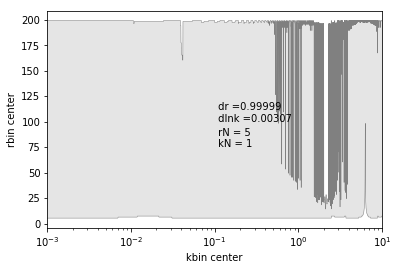

In [47]:
rN = 5
kN = 1

dir = '../data_txt/consistency_check_rN5_kN1/'
filename = dir+'/consistency_check_rlim.txt'
kcenter, effec_rmax, effec_rmin = np.loadtxt(filename, unpack=True)
fig, ax =plt.subplots()
ax.plot(kcenter, effec_rmax, '-', color='grey', linewidth = 0.5)
ax.plot(kcenter, effec_rmin, '-', color ='grey', linewidth = 0.5)

ax.fill_between(kcenter, effec_rmax, effec_rmin, where=effec_rmax >= effec_rmin, 
                facecolor='grey', alpha = 0.2, interpolate=True)

ax.set_ylabel('rbin center')
ax.set_xlabel('kbin center')
ax.text(0.1, 100, ' dr ={:0.5f}\n dlnk ={:0.5f}'.format(cosmo.dr, cosmo.dlnk) )
ax.text(0.1, 75, ' rN = {}\n kN = {}'.format(rN, kN))
ax.legend(loc='best')
ax.set_xlim(1e-03, 10)
ax.set_xscale('log')

fig.savefig(dir+'fig.png')

##### rN = 1,  kN = 100

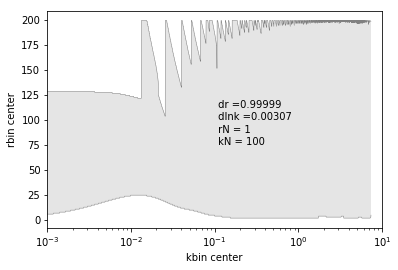

In [52]:
rN = 1
kN = 100

dir = '../data_txt/consistency_check_rN1_kN100/'
filename = dir+'/consistency_check_rlim.txt'
kcenter, effec_rmax, effec_rmin = np.loadtxt(filename, unpack=True)
fig, ax =plt.subplots()
ax.plot(kcenter, effec_rmax, '-', color='grey', linewidth = 0.5)
ax.plot(kcenter, effec_rmin, '-', color ='grey', linewidth = 0.5)
ax.fill_between(kcenter, effec_rmax, effec_rmin, where=effec_rmax >= effec_rmin, 
                facecolor='grey', alpha = 0.2, interpolate=True)

ax.set_ylabel('rbin center')
ax.set_xlabel('kbin center')
ax.text(0.1, 100, ' dr ={:0.5f}\n dlnk ={:0.5f}'.format(cosmo.dr, cosmo.dlnk) )
ax.text(0.1, 75, ' rN = {}\n kN = {}'.format(rN, kN))
ax.legend(loc='best')
ax.set_xlim(1e-03, 10)
ax.set_xscale('log')

fig.savefig(dir+'fig.png')

In [55]:
rN = 5
kN = 100

dir = '../data_txt/consistency_check_rN5_kN100/'
filename = dir+'/consistency_check_rlim.txt'
kcenter, effec_rmax, effec_rmin = np.loadtxt(filename, unpack=True)
fig, ax =plt.subplots()
ax.plot(kcenter, effec_rmax, '-', color='grey', linewidth = 0.5)
ax.plot(kcenter, effec_rmin, '-', color ='grey', linewidth = 0.5)
ax.fill_between(kcenter, effec_rmax, effec_rmin, where=effec_rmax >= effec_rmin, 
                facecolor='grey', alpha = 0.2, interpolate=True)

ax.set_ylabel('rbin center')
ax.set_xlabel('kbin center')
ax.text(0.1, 100, ' dr ={:0.5f}\n dlnk ={:0.5f}'.format(cosmo.dr, cosmo.dlnk) )
ax.text(0.1, 75, ' rN = {}\n kN = {}'.format(rN, kN))
ax.legend(loc='best')
ax.set_xlim(1e-03, 10)
ax.set_xscale('log')

fig.savefig(dir+'fig.png')

IOError: ../data_txt/consistency_check_rN5_kN100//consistency_check_rlim.txt not found.